In [1]:
!nvidia-smi

Fri Aug  9 16:42:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setup

In [80]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

In [4]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors, patches
import numpy as np

# Download dataset

In [5]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [6]:
def load_data(jsonData, dataFolderPath, training_or_test,filterString='0001'):
    images = []
    labels = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.').replace(".csv",".nii.gz")).get_fdata()
        images.append(image.astype(np.uint8))
        if training_or_test == 'training':
          label = nib.load(dataFolderPath + sample['label'].removeprefix('.').replace(".csv",".nii.gz")).get_fdata()
          labels.append(label.astype(np.uint8))

    return np.array(images), np.array(labels)

In [7]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './AbdomenCTCT'
training_images_raw, training_labels_raw = load_data(data_json, dataFolder, 'training')

In [8]:
training_images_raw.shape

(30, 192, 160, 256)

In [9]:
training_labels_raw.shape

(30, 192, 160, 256)

# Preprocess data

In [10]:
# normalize images
training_images_normalized = training_images_raw / 255.

# rotate tensor
training_images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in training_images_normalized])
training_labels_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in training_labels_raw])

# swap and flip axes
training_images = np.swapaxes(training_images_rotated, 1, 2)[:, ::-1, :, :]
training_labels = np.swapaxes(training_labels_rotated, 1, 2)[:, ::-1, :, :]

# prepare tensor just with organs
training_organs = np.zeros_like(training_images)
training_organs[training_labels > 0] = training_images[training_labels > 0]

del training_images_raw
del training_labels_raw
del training_images_normalized
del training_images_rotated
del training_labels_rotated

(-0.5, 191.5, 255.5, -0.5)

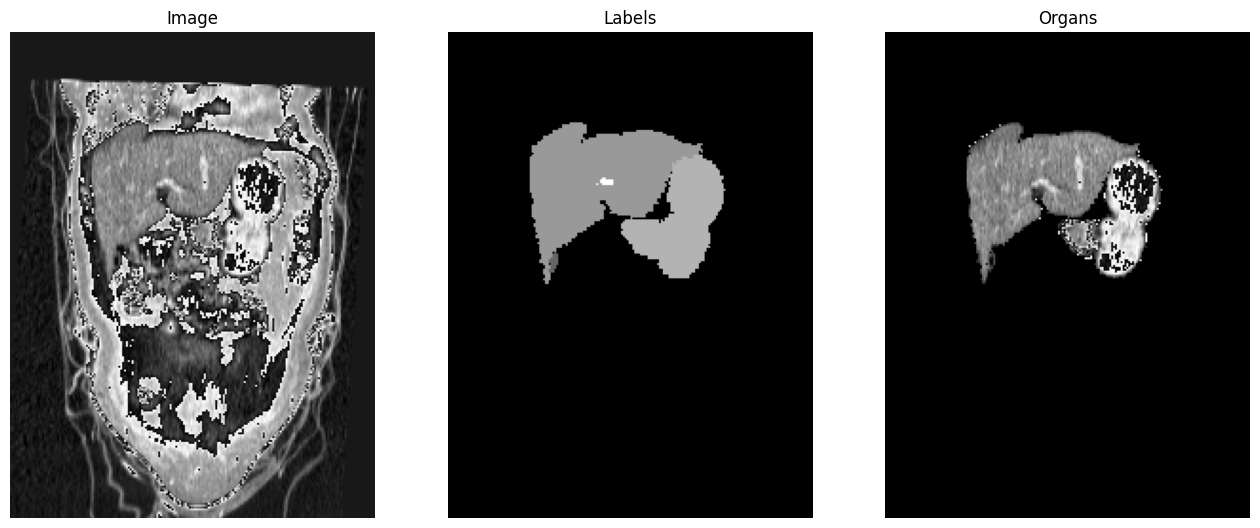

In [29]:
# preview data
img = 0
depth = 40

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(training_images[img,depth],cmap='gray')
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(training_labels[img,depth], cmap='gray')
ax1.set_title("Labels")
ax1.axis("off")
ax2.imshow(training_organs[img,depth], cmap='gray')
ax2.set_title("Organs")
ax2.axis("off")

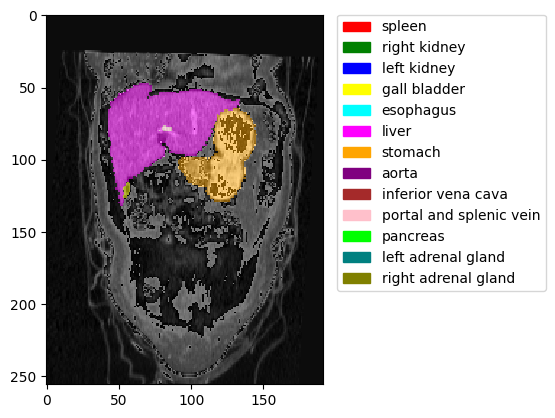

In [12]:
# setup colormap
cmap = colors.ListedColormap([
    'black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange',
    'purple', 'brown', 'pink', 'lime', 'teal', 'olive'
])
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, 14, 1), ncolors=14)

# view image
plt.imshow(training_images[img,depth], cmap='gray', interpolation='none')

# view colors
plt.imshow(training_labels[img,depth], cmap=cmap, norm=norm, alpha=0.5, interpolation='none')

# setup legend
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# view rectangles in legend
patches_list = [
    patches.Patch(color=cmap(i), label=legend_labels[i])
    for i in range(1, 14)
]

# view legend
plt.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# Define Model

In [15]:
# define the input shapes
inshape = training_organs.shape[1:]
nb_features = (
    (16, 32, 32), # encoder-channels
    (32, 32, 16, 16) # eecoder-channels
    )
# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 160, 256, 192, 1), (None, 160, 256, 192, 1)
output shape: (None, 160, 256, 192, 1), (None, 160, 256, 192, 3)


In [16]:
# define loss functions
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# balance the two losses with hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [17]:
# compile model
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train model

In [53]:
# define a data generator that adds augmentation
def vxm_data_generator(data1, data2, batch_size=16, augmentation=True):
    vol_shape = data1.shape[1:]
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        idx1 = np.random.randint(0, data1.shape[0], size=batch_size)
        idx2 = np.random.randint(0, data2.shape[0], size=batch_size)

        fixed_image = data1[idx1, ..., np.newaxis]
        moving_image = data2[idx2, ..., np.newaxis]

        # add augmentation?

        inputs = [moving_image, fixed_image]
        outputs = [fixed_image, zero_phi]

        yield (inputs, outputs)

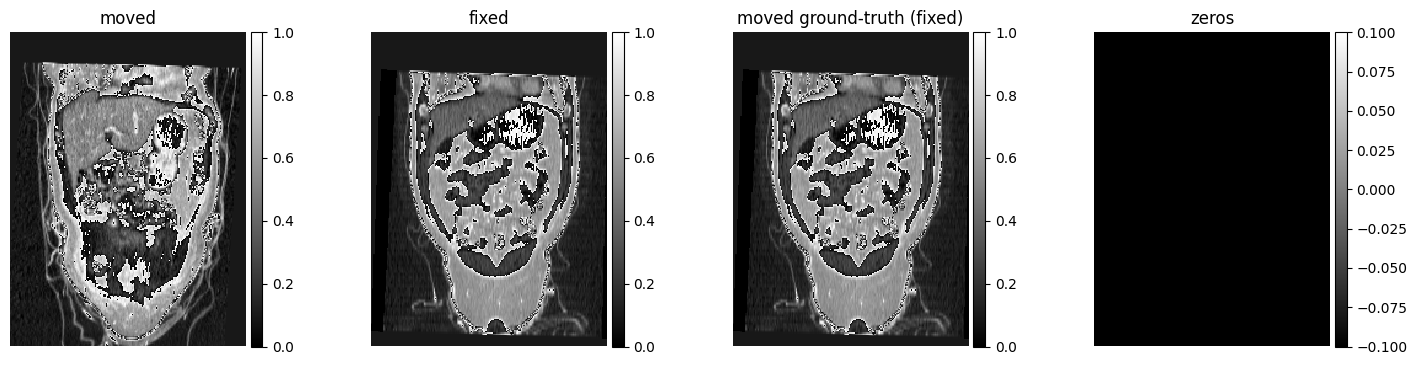

In [55]:
batch_size = 1

# define training generator
train_generator = vxm_data_generator(training_images, training_images, batch_size=batch_size)
in_sample, out_sample = next(train_generator)

# view generated data
images = [img[0, depth] for img in in_sample + out_sample]
titles = ['moved', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [34]:
# train model
nb_epochs = 30
steps_per_epoch = 20
validation_steps = 2
hist = vxm_model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=2
)

Epoch 1/30
20/20 - 88s - loss: 0.0901 - vxm_dense_transformer_loss: 0.0901 - vxm_dense_flow_loss: 3.1521e-04 - 88s/epoch - 4s/step
Epoch 2/30
20/20 - 28s - loss: 0.0905 - vxm_dense_transformer_loss: 0.0905 - vxm_dense_flow_loss: 4.1676e-04 - 28s/epoch - 1s/step
Epoch 3/30
20/20 - 27s - loss: 0.0907 - vxm_dense_transformer_loss: 0.0907 - vxm_dense_flow_loss: 6.5801e-04 - 27s/epoch - 1s/step
Epoch 4/30
20/20 - 28s - loss: 0.0854 - vxm_dense_transformer_loss: 0.0854 - vxm_dense_flow_loss: 0.0014 - 28s/epoch - 1s/step
Epoch 5/30
20/20 - 28s - loss: 0.0841 - vxm_dense_transformer_loss: 0.0838 - vxm_dense_flow_loss: 0.0059 - 28s/epoch - 1s/step
Epoch 6/30
20/20 - 28s - loss: 0.0951 - vxm_dense_transformer_loss: 0.0943 - vxm_dense_flow_loss: 0.0166 - 28s/epoch - 1s/step
Epoch 7/30
20/20 - 27s - loss: 0.0864 - vxm_dense_transformer_loss: 0.0860 - vxm_dense_flow_loss: 0.0080 - 27s/epoch - 1s/step
Epoch 8/30
20/20 - 28s - loss: 0.0943 - vxm_dense_transformer_loss: 0.0925 - vxm_dense_flow_loss: 0

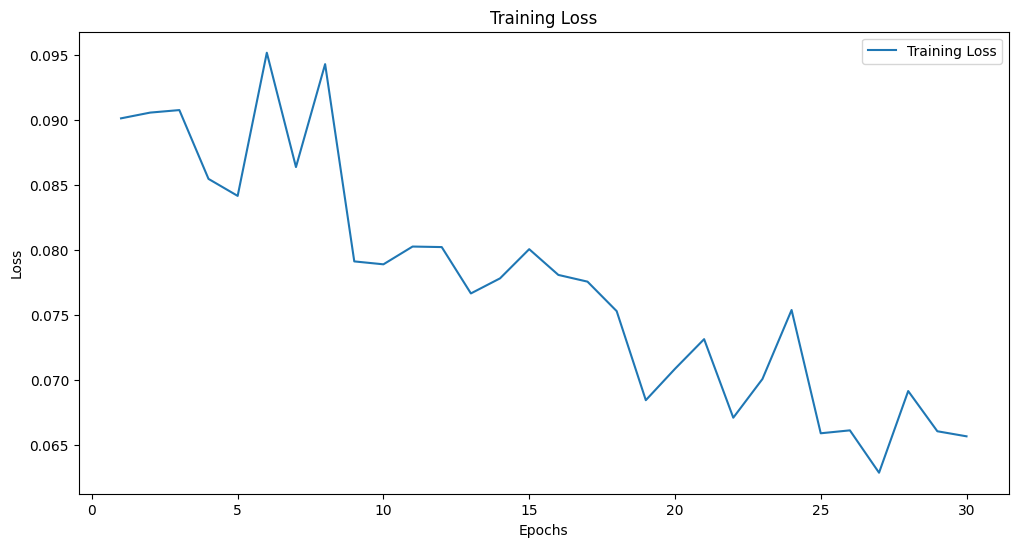

In [35]:
# extract train- and validation-loss
train_loss = hist.history['loss']

# plot history
plt.figure(figsize=(12, 6))
plt.plot(range(1, nb_epochs + 1), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Test registration

In [36]:
test_images_raw, _ = load_data(data_json, dataFolder, 'test')

In [38]:
# normalize images
test_images_normalized = test_images_raw / 255.

# rotate tensor
test_images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in test_images_normalized])

# swap and flip axes
test_images = np.swapaxes(test_images_rotated, 1, 2)[:, ::-1, :, :]

del test_images_raw
del test_images_normalized
del test_images_rotated

In [41]:
test_images.shape

(20, 160, 256, 192)

In [57]:
# define validation generator
test_generator = vxm_data_generator(test_images, training_images, batch_size = 1, augmentation=False)
test_input, _ = next(test_generator)

In [58]:
# perform prediction
test_pred = vxm_model.predict(test_input)

1/1 [==============================] - 1s 684ms/step


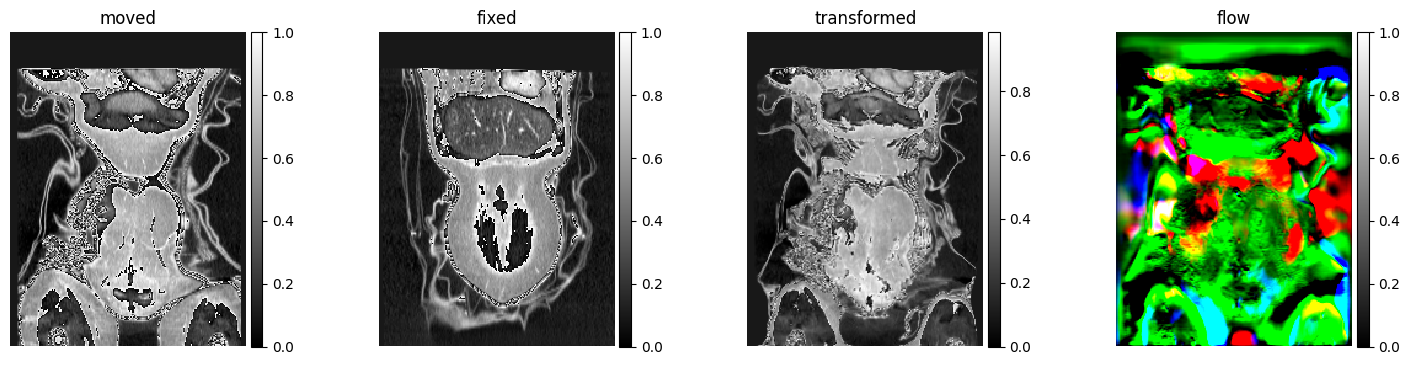

In [59]:
# view result
images = [img[0, depth] for img in test_input + test_pred]
titles = ['moved', 'fixed', 'transformed', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [60]:
def find_subarray(arr,subarr):
  for idx, val in enumerate(arr):
    if np.array_equal(val, subarr):
      return idx

In [78]:
def apply_displacement_field(input_image, displacement_field, iterations=1):
  h, w, d = input_image.shape

  # Apply displacement field to original resized picture using spatial transformer
  inputs_image = tf.keras.Input(shape=(h, w, d, 1))
  inputs_disp = tf.keras.Input(shape=(h, w, d, 3))

  spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')
  moved_image = spatial_transformer([inputs_image, inputs_disp])

  # Define model
  transformer_model = tf.keras.Model(inputs=[inputs_image, inputs_disp], outputs=moved_image)

  # Make prediction
  for i in range(iterations):
    input_image = transformer_model.predict([np.expand_dims(input_image, axis=0), np.expand_dims(displacement_field, axis=0)])[0]

  return np.squeeze(input_image, axis=-1)

In [81]:
idx = find_subarray(training_images,np.squeeze(test_input[0][0],-1))

displacement_field = test_pred[1][0]
input_image = training_labels[idx]

predicted_image = apply_displacement_field(input_image,displacement_field)

1/1 [==============================] - 1s 1s/step


(-0.5, 191.5, 255.5, -0.5)

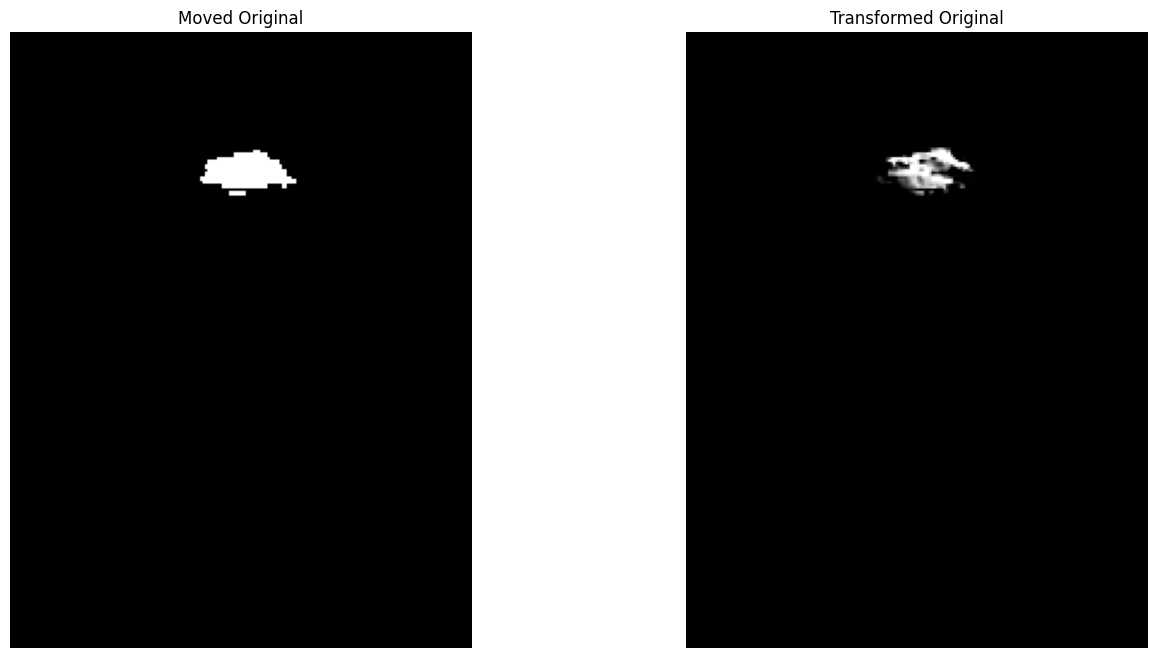

In [84]:
# view applied field on original picture
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,8))
ax0.imshow(input_image[depth], cmap='gray')
ax0.set_title("Moved Original")
ax0.axis("off")
ax1.imshow(predicted_image[depth], cmap='gray')
ax1.set_title("Transformed Original")
ax1.axis("off")

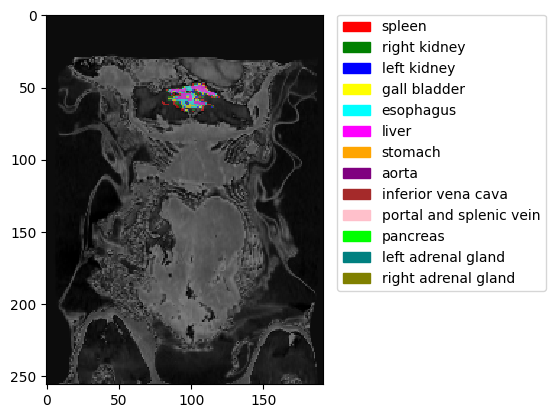

In [87]:
# setup colormap
cmap = colors.ListedColormap([
    'black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange',
    'purple', 'brown', 'pink', 'lime', 'teal', 'olive'
])
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, 14, 1), ncolors=14)

# view image
plt.imshow(test_pred[0][0][depth], cmap='gray', interpolation='none')

# view colors
plt.imshow(predicted_image[depth], cmap=cmap, norm=norm, alpha=0.5, interpolation='none')

# setup legend
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# view rectangles in legend
patches_list = [
    patches.Patch(color=cmap(i), label=legend_labels[i])
    for i in range(1, 14)
]

# view legend
plt.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# Save model

In [39]:
vxm_model.save_weights('MIR_abdomen.h5')

# Load model

In [ ]:
vxm_model.load_weights('MIR_weights.h5')